#  Panama Papers: Data Challenge

Explore the dataset

In [10]:
%matplotlib inline

import copy
import matplotlib.colors
from matplotlib.patches import Polygon

from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch


from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

import mpl_toolkits.basemap
reload(mpl_toolkits.basemap)
from mpl_toolkits.basemap import Basemap

import seaborn as sns
sns.set_style('white')


import geocoder
import pycountry
from pymendez import auth
from pysurvey.plot import setup_sns as setup, icolorbar
import pandas as pd
import numpy as np

import geoplotlib, geoplotlib.utils

In [2]:
key = auth.auth('google_geocode', 'key')

In [5]:
addresses = pd.read_csv('/Users/ajmendez/Desktop/panama/offshore_leaks_csvs-20160621/Addresses.csv')
print len(addresses)
addresses.head(1)

151054


,address,icij_id,valid_until,country_codes,countries,node_id,sourceID
0,-\t27 ROSEWOOD DRIVE #16-19 SINGAPORE 737920,6991059DFFB057DF310B9BF31CC4A0E6,The Panama Papers data is current through 2015,SGP,Singapore,14000001,Panama Papers


In [43]:
inter = pd.read_csv('/Users/ajmendez/Desktop/panama/offshore_leaks_csvs-20160621/all_edges.csv')
print len(inter)
inter.head(1)

1269796


,node_1,rel_type,node_2
0,11000001,intermediary of,10208879


In [42]:
inter.columns

Index([u'name', u'original_name', u'former_name', u'jurisdiction',
       u'jurisdiction_description', u'company_type', u'address',
       u'internal_id', u'incorporation_date', u'inactivation_date',
       u'struck_off_date', u'dorm_date', u'status', u'service_provider',
       u'ibcRUC', u'country_codes', u'countries', u'note', u'valid_until',
       u'node_id', u'sourceID'],
      dtype='object')

In [6]:
countries = pd.DataFrame(data={'code':addresses['country_codes'].dropna().unique()},
                         columns=['code', 'naddr', 'name', 'lat', 'lon'])

In [7]:
N = addresses['country_codes'].value_counts()
for i, code in enumerate(countries['code']):
    if (code == 'XXX'):
        continue

    name = pycountry.countries.get(alpha3=code).name
    geo = geocoder.google(name, key=key)
    countries.loc[i, 'name'] = name
    countries.loc[i, 'lon'] = geo.lng
    countries.loc[i, 'lat'] = geo.lat
    countries.loc[i, 'naddr'] = N[code]

In [8]:
countries['logaddr'] = np.log10(np.array(countries['naddr'].astype(np.float)))

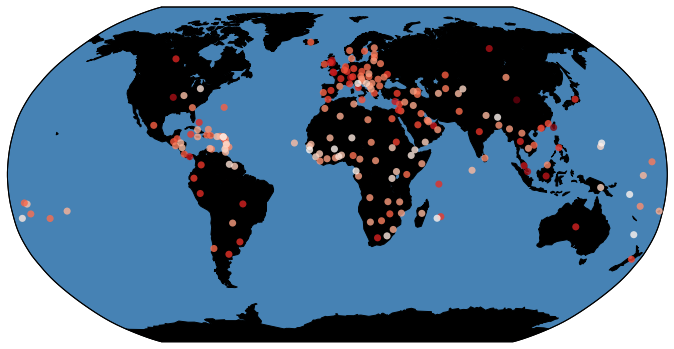

In [9]:
# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
plt.figure(figsize=(12,6))
m = Basemap(projection='robin',lon_0=0,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='black', lake_color='steelblue')
# draw parallels and meridians.
# m.drawparallels(np.arange(-90.,120.,30.))
# m.drawmeridians(np.arange(0.,420.,60.))
m.drawmapboundary(fill_color='steelblue')
x,y = m(np.array(countries['lon']), np.array(countries['lat']))
sca = m.scatter(x,y, c=np.log10(np.array(countries['naddr'].astype(np.float))), 
          s=50, zorder=20, lw=0, alpha=0.8,
          cmap=plt.cm.Reds)
# plt.title("Mollweide Projection")
# plt.show()



# Normalize by People

In [11]:
pop = pd.read_csv("/Users/ajmendez/Downloads/countries.csv", delimiter=';')
pop.head()

,Country (en),Country (de),Country (local),Country code,Continent,Capital,Population,Area,Coastline,Government form,Currency,Currency code,Dialing prefix,Birthrate,Deathrate,Life expectancy,Url
0,Afghanistan,Afghanistan,Afganistan/Afqanestan,AF,Asia,NaN,32564342,652230,0,islamic republic,Afghani,AFN,93,38.6,13.9,50.9,https://www.laenderdaten.info/Asien/Afghanista...
1,Egypt,Ägypten,Misr,EG,Africa,NaN,88487396,1001450,2450,republic,Pfund,EGP,20,22.9,4.8,73.7,https://www.laenderdaten.info/Afrika/Aegypten/...
2,Albania,Albanien,Shqipëria,AL,Europe,NaN,3029278,28748,362,republic,Lek,ALL,355,12.9,6.6,78.1,https://www.laenderdaten.info/Europa/Albanien/...
3,Algeria,Algerien,Al-Jaza’ir/Algérie,DZ,Africa,NaN,39542166,2381741,998,republic,Dinar,DZD,213,23.7,4.3,76.6,https://www.laenderdaten.info/Afrika/Algerien/...
4,American Samoa,Amerikanisch Samoa,Amerika Samoa,AS,Oceania,NaN,54343,199,116,territory of the United States,Dollar,USD,1-684,22.9,4.8,75.1,https://www.laenderdaten.info/Ozeanien/Amerika...


In [12]:
countries['pop'] = 0
for code in countries['code']:
    if code == 'XXX':
        continue
    
    alpha2 = pycountry.countries.get(alpha3=code).alpha2
    tmp = pop[pop['Country code'] == alpha2]
    if len(tmp)== 0:
        continue
    
    countries.loc[countries['code'] == code, 'pop'] = tmp['Population'].values[0]

In [13]:
# Missing population data -- drop for simplicity
countries[countries['pop'] == 0]

,code,naddr,name,lat,lon,logaddr,pop
120,NAM,23,Namibia,-22.9576,18.4904,1.361728,0
154,MAF,1,Saint Martin (French part),18.0692,-63.0372,0.000000,0
202,XXX,NaN,NaN,NaN,NaN,NaN,0


In [14]:
countries['ratio'] = (countries['naddr'] / (1+countries['pop'])).map(np.log10)
countries['logpop'] = countries['pop'].map(np.log10)

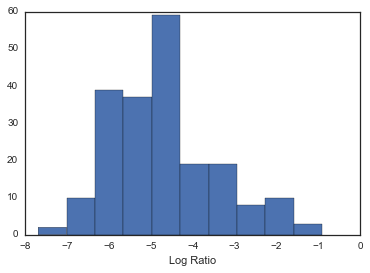

In [15]:
plt.hist(countries[countries['pop']>0]['ratio'].values)
plt.xlabel('Log Ratio')

In [16]:
countries[countries['pop']>0].sort_values('ratio', ascending=False).head(15)

,code,naddr,name,lat,lon,logaddr,pop,ratio,logpop
29,VGB,4125,"Virgin Islands, British",54.1067,-3.2473,3.615424,33454,-0.909037,4.524448
147,NIU,139,Niue,-19.0544,-169.867,2.143015,1190,-0.932897,3.075547
38,JEY,3013,Jersey,49.2144,-2.13125,3.478999,97294,-1.509091,4.988086
3,GGY,1671,Guernsey,49.4657,-2.58528,3.222976,66080,-1.597100,4.820070
5,MCO,589,Monaco,43.7384,7.42462,2.770115,30535,-1.714697,4.484798
124,LIE,690,Liechtenstein,47.166,9.55537,2.838849,37624,-1.736627,4.575465
83,COK,152,Cook Islands,-21.2367,-159.778,2.181844,9838,-1.811107,3.992907
56,GIB,440,Gibraltar,36.1408,-5.35358,2.643453,29258,-1.822807,4.466245
51,IMN,1171,Isle of Man,54.2361,-4.54806,3.068557,87545,-1.873679,4.942231
90,CYM,646,Cayman Islands,19.3133,-81.2546,2.810233,56092,-1.938676,4.748901


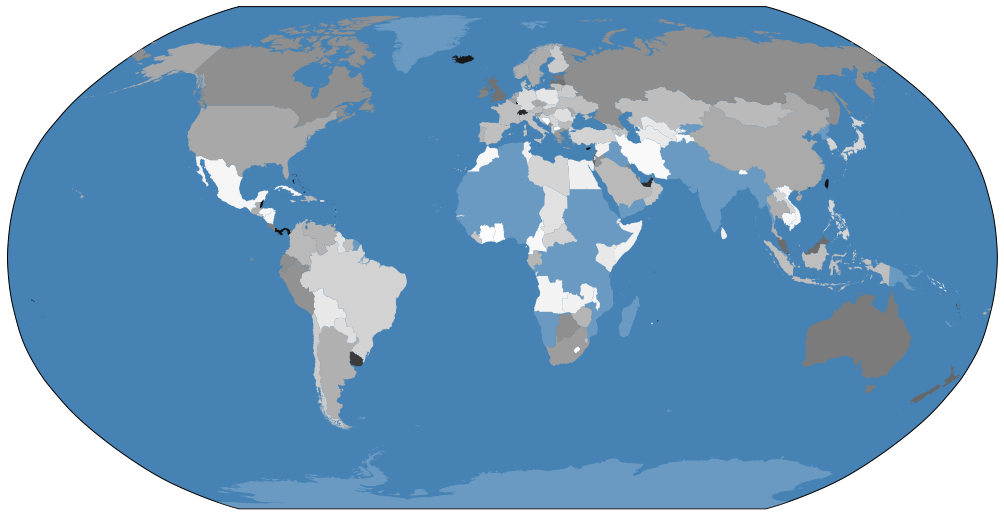

In [17]:

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)

m = Basemap(projection='robin',lon_0=0,resolution='c')
m.drawmapboundary(fill_color='steelblue')
# m.fillcontinents(color='black', lake_color='steelblue')

shapefile = '/Users/ajmendez/Downloads/TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3'
m.readshapefile(shapefile, 'countries', color=(1,1,1,0.5), linewidth=0.2, drawbounds=False)




patches = []
colors = []
cmap = copy.copy(plt.cm.Greys)
cmap.set_bad((1,0,0, 0.5))

norm = matplotlib.colors.Normalize(-6, -3, clip=True)

patches2 = []

for shape,info in zip(m.countries, m.countries_info):
    tmp = countries.loc[ (countries['code'] == info['ISO3']) & 
                         (countries['ratio'] > -6) &
                         (countries['pop'] > 0) ]
    if (len(tmp) == 0):
        patches2.append(Polygon(np.array(shape), True))
        continue
    
    color = norm(tmp['ratio'])[0]    
    poly = Polygon(np.array(shape), True)
    patches.append(poly)
    colors.append(color)

    
pc = PatchCollection(patches2, facecolors=(1,1,1,0.2), linewidths=0, zorder=2)    
ax.add_collection(pc)
    
pc = PatchCollection(patches, cmap=cmap, linewidths=0, zorder=2)    
pc.set_array(np.array(colors))
pc.set_clim(0,1)
ax.add_collection(pc)


None

# Normalize by GDP

In [21]:
gdp = pd.read_csv("/Users/ajmendez/tmp/world/API_NY.GDP.MKTP.CD_DS2_en_csv_v2.csv",
                  comment='#')
gdp.head()

,"﻿""Country Name""",Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
0,Aruba,ABW,GDP at market prices (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.623726e+09,2.791961e+09,2.498933e+09,2.467704e+09,2.584464e+09,NaN,NaN,NaN,NaN,NaN
1,Andorra,AND,GDP at market prices (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.010785e+09,4.001349e+09,3.649863e+09,3.346317e+09,3.427236e+09,3.146178e+09,3.249101e+09,NaN,NaN,NaN
2,Afghanistan,AFG,GDP at market prices (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,9.843842e+09,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.004633e+10,2.005019e+10,1.919944e+10,NaN
3,Angola,AGO,GDP at market prices (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,6.044892e+10,8.417803e+10,7.549238e+10,8.247091e+10,1.041159e+11,1.153984e+11,1.249121e+11,1.267751e+11,1.026431e+11,NaN
4,Albania,ALB,GDP at market prices (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.070101e+10,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.278103e+10,1.327796e+10,1.145560e+10,NaN


In [24]:
countries['gdp'] = 0
for code in countries['code']:
    if code == 'XXX':
        continue
    
    tmp = gdp[gdp['Country Code'] == code]
    if len(tmp)== 0:
        continue
    
    countries.loc[countries['code'] == code, 'gdp'] = gdp['2011']

In [27]:
countries[countries['gdp'] == 0]

,code,naddr,name,lat,lon,logaddr,pop,ratio,logpop,gdp
3,GGY,1671,Guernsey,49.4657,-2.58528,3.222976,66080,-1.597100,4.820070,0
21,TWN,14610,"Taiwan, Province of China",22.6158,120.712,4.164650,23415126,-3.204846,7.369496,0
27,AIA,115,Anguilla,18.2206,-63.0686,2.060698,16418,-2.154649,4.215320,0
38,JEY,3013,Jersey,49.2144,-2.13125,3.478999,97294,-1.509091,4.988086,0
83,COK,152,Cook Islands,-21.2367,-159.778,2.181844,9838,-1.811107,3.992907,0
132,MTQ,4,Martinique,14.6415,-61.0242,0.602060,395000,-4.994538,5.596597,0
147,NIU,139,Niue,-19.0544,-169.867,2.143015,1190,-0.932897,3.075547,0
196,REU,1,Réunion,-21.1151,55.5364,0.000000,699000,-5.844478,5.844477,0
202,XXX,NaN,NaN,NaN,NaN,NaN,0,NaN,-inf,0
206,NFK,1,Norfolk Island,-29.0408,167.955,0.000000,2210,-3.344589,3.344392,0


In [47]:
countries['lognaddr'] = countries['naddr'].map(np.log10)
countries['loggdp'] = countries['gdp'].map(np.log10)
countries['gdpratio'] = (countries['naddr'] /(1 + countries['gdp'])).map(np.log10)

(array([  3.,   6.,  11.,  20.,  20.,  33.,  33.,  35.,  20.,   5.]),
 array([-13.65548591, -12.85537406, -12.05526221, -11.25515036,
        -10.45503851,  -9.65492667,  -8.85481482,  -8.05470297,
         -7.25459112,  -6.45447927,  -5.65436743]),
 <a list of 10 Patch objects>)

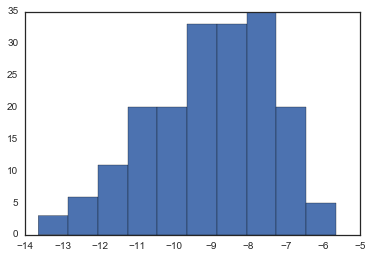

In [35]:
plt.hist(countries[countries['gdp'] > 0]['gdpratio'].values)

In [37]:
countries[countries['gdp']>0].sort_values('gdpratio', ascending=False).head(15)

,code,naddr,name,lat,lon,logaddr,pop,ratio,logpop,gdp,loggdp,gdpratio
0,SGP,5728,Singapore,1.35208,103.82,3.758003,5674472,-2.995923,6.753925,2.584464e+09,9.412370,-5.654367
53,PAN,2732,Panama,8.53798,-80.7821,3.436481,3657024,-3.126647,6.563128,1.239145e+09,9.093122,-5.656641
22,HKG,21041,Hong Kong,22.3964,114.109,4.323066,7141106,-2.530699,6.853765,1.862802e+10,10.270167,-5.947100
54,GTM,283,Guatemala,15.7835,-90.2308,2.451786,14918999,-4.721953,7.173740,5.014815e+08,8.700255,-6.248468
13,CHN,28073,China,35.8617,104.195,4.448289,1367485388,-4.687634,9.135923,6.595163e+10,10.819226,-6.370937
16,MYS,2722,Malaysia,4.21048,101.976,3.434888,30513848,-4.049609,7.484497,7.814081e+09,9.892878,-6.457990
88,SYC,871,Seychelles,-4.67957,55.492,2.940018,92430,-2.025799,4.965813,2.503748e+09,9.398591,-6.458572
14,JPN,805,Japan,36.2048,138.253,2.905796,126919659,-5.197733,8.103529,2.355652e+09,9.372111,-6.466315
121,LKA,53,Sri Lanka,7.87305,80.7718,1.724276,22053488,-5.619201,7.343477,1.722537e+08,8.236169,-6.511893
26,USA,6860,United States,37.0902,-95.7129,3.836324,321368864,-4.670680,8.507004,2.396303e+10,10.379542,-6.543218


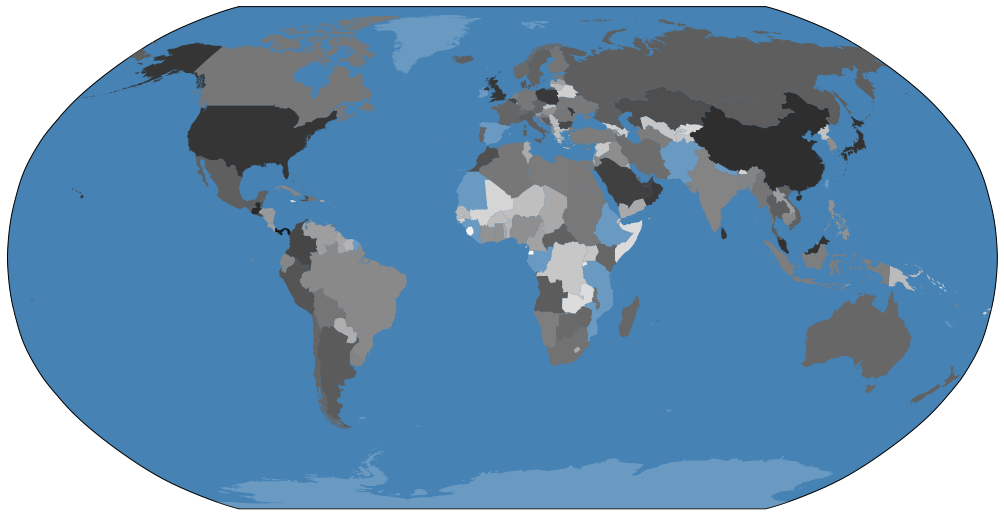

In [39]:

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)

m = Basemap(projection='robin',lon_0=0,resolution='c')
m.drawmapboundary(fill_color='steelblue')
# m.fillcontinents(color='black', lake_color='steelblue')

shapefile = '/Users/ajmendez/Downloads/TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3'
m.readshapefile(shapefile, 'countries', color=(1,1,1,0.5), linewidth=0.2, drawbounds=False)




patches = []
colors = []
cmap = copy.copy(plt.cm.Greys)
cmap.set_bad((1,0,0, 0.5))

norm = matplotlib.colors.Normalize(-14, -5, clip=True)

patches2 = []

for shape,info in zip(m.countries, m.countries_info):
    tmp = countries.loc[ (countries['code'] == info['ISO3']) & 
                         (countries['gdpratio'] > -14) &
                         (countries['gdp'] > 0) ]
    if (len(tmp) == 0):
        patches2.append(Polygon(np.array(shape), True))
        continue
    
    color = norm(tmp['gdpratio'])[0]    
    poly = Polygon(np.array(shape), True)
    patches.append(poly)
    colors.append(color)

    
pc = PatchCollection(patches2, facecolors=(1,1,1,0.2), linewidths=0, zorder=2)    
ax.add_collection(pc)
    
pc = PatchCollection(patches, cmap=cmap, linewidths=0, zorder=2)    
pc.set_array(np.array(colors))
pc.set_clim(0,1)
ax.add_collection(pc)


None

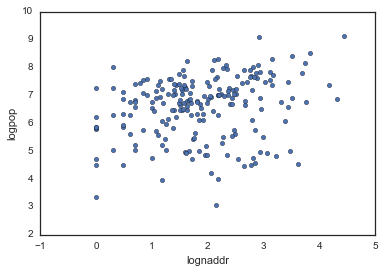

In [49]:
countries.plot('lognaddr', 'logpop', kind='scatter')